In [1]:
import sys
sys.path.append('../implementation')
import numpy as np
import pandas as pd
import ast
from tqdm import tqdm
from util import lognormpdf
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
import scipy.stats as stats
import scikit_posthocs as sci_post
import time
import warnings
import seaborn as sns
from statistics import mean
warnings.filterwarnings('ignore')

In [2]:
# Load results
vast_results_hmm = pd.read_pickle('../output/vast/vast_11_hmm.pkl')
vast_results_cm = pd.read_pickle('../output/vast/vast_11_cm.pkl')
vast_results_wall = pd.read_pickle('../output/vast/vast_11_wall.pkl')
vast_results_knn = pd.read_pickle('../output/vast/vast_11_knn.pkl')
vast_results_ac = pd.read_pickle('../output/vast/vast_11_ac.pkl')
vast_results_af = pd.read_pickle('../output/vast/vast_11_af.pkl')
vast_results_ada = pd.read_pickle('../output/vast/vast_11_ada_nb.pkl')

# vast_results_wall['bias-latitude___longitude'] = vast_results_wall['bias-latitude'] * vast_results_wall['bias-longitude']

ks = [1, 5, 10, 20, 50, 100]

In [3]:
avg_rank = pd.DataFrame()

t = 'control'
for i, row in vast_results_hmm[vast_results_hmm.task == t].iterrows():
    average_rank = mean(row['rank'])
    temp_df = pd.DataFrame({'alg': ['hmm'], 'task': [t], 'average_rank': [average_rank]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
for i, row in vast_results_cm[vast_results_cm.task == t].iterrows():
    average_rank = mean(row['rank'])
    temp_df = pd.DataFrame({'alg': ['cm'], 'task': [t], 'average_rank': [average_rank]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
for i, row in vast_results_af[vast_results_af.task == t].iterrows():
    average_rank = mean(row['rank'])
    temp_df = pd.DataFrame({'alg': ['af'], 'task': [t], 'average_rank': [average_rank]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
for i, row in vast_results_knn[vast_results_knn.task == t].iterrows():
    average_rank = mean(row['rank'])
    temp_df = pd.DataFrame({'alg': ['knn'], 'task': [t], 'average_rank': [average_rank]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
for i, row in vast_results_ada[vast_results_ada.task == t].iterrows():
    average_rank = mean(row['rank'])
    temp_df = pd.DataFrame({'alg': ['ada_nb'], 'task': [t], 'average_rank': [average_rank]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)

# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
def run_comp(data, task, alpha=0.05):
    posthoc_dun = None
    avg_rank_data = data[data['task'] == task].dropna()
    hmm_rank_val = avg_rank_data[avg_rank_data['alg'] == 'hmm']['average_rank'].values
    cm_rank_val = avg_rank_data[avg_rank_data['alg'] == 'cm']['average_rank'].values
    af_rank_val = avg_rank_data[avg_rank_data['alg'] == 'af']['average_rank'].values
    knn_rank_val = avg_rank_data[avg_rank_data['alg'] == 'knn']['average_rank'].values
    ada_nb_rank_val = avg_rank_data[avg_rank_data['alg'] == 'ada_nb']['average_rank'].values
    
    hmm_p = stats.shapiro(hmm_rank_val).pvalue
    cm_p = stats.shapiro(cm_rank_val).pvalue
    af_p = stats.shapiro(af_rank_val).pvalue
    knn_p = stats.shapiro(knn_rank_val).pvalue
    ada_nb_p = stats.shapiro(ada_nb_rank_val).pvalue
    norm_p = np.array([hmm_p, cm_p, af_p, knn_p, ada_nb_p])
    
    if all(p >= alpha for p in norm_p):
        print('ANOVA')
        statistic, pvalue = stats.f_oneway(hmm_rank_val, cm_rank_val, af_rank_val, knn_rank_val, ada_nb_rank_val)
    else:
        print('Kruskal')
        kruskal_res = stats.kruskal(hmm_rank_val, cm_rank_val, af_rank_val, knn_rank_val, ada_nb_rank_val)
        statistic = kruskal_res.statistic
        pvalue = kruskal_res.pvalue
        if pvalue <= alpha:
            posthoc_dun = sci_post.posthoc_dunn(avg_rank_data, val_col='average_rank',
                                          group_col = 'alg', p_adjust = 'bonferroni')
    return statistic, pvalue, posthoc_dun

statistic, p_val, posthoc_dun = run_comp(avg_rank, t)
print(f'{t}\nstatistic: {statistic}, p_val: {p_val}\nmult_comp:\n {posthoc_dun}\n')
control_data = avg_rank[avg_rank['task'] == 'control'].dropna()
sns.catplot(
    data=control_data, x='average_rank', y='alg', kind='box', height=5
).set(title='Average Rank Per Session for VAST')

StatisticsError: mean requires at least one data point

In [ ]:
fig = plt.figure(figsize=(2*6.4, 4.8))
plt.rcParams.update({'axes.titlesize': 15, 'axes.labelsize': 15, 'xtick.labelsize':12, 'xtick.labelsize':12})
ax = fig.add_axes([0,0,1,1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.set(xlabel='Interactions Observed', ylabel='Avg. Rank')
ax.set_ylim((0, 2000))
#     ax.set_xlim((2, 12))

t = 'control'
rank_over_time_hmm = pd.DataFrame()
rank_over_time_cm = pd.DataFrame()
rank_over_time_af = pd.DataFrame()
rank_over_time_knn = pd.DataFrame()
rank_over_time_ada_nb = pd.DataFrame()
for i, row in vast_results_hmm[vast_results_hmm.task == t].iterrows():
    temp_df = pd.DataFrame()
    temp_df[row['participant_id']] = row['rank']
    rank_over_time_hmm = pd.concat([rank_over_time_hmm, temp_df], axis=1, ignore_index=True)
for i, row in vast_results_cm[vast_results_cm.task == t].iterrows():
    temp_df = pd.DataFrame()
    temp_df[row['participant_id']] = row['rank']
    rank_over_time_cm = pd.concat([rank_over_time_cm, temp_df], axis=1, ignore_index=True)
for i, row in vast_results_af[vast_results_af.task == t].iterrows():
    temp_df = pd.DataFrame()
    temp_df[row['participant_id']] = row['rank']
    rank_over_time_af = pd.concat([rank_over_time_af, temp_df], axis=1, ignore_index=True)
for i, row in vast_results_knn[vast_results_knn.task == t].iterrows():
    temp_df = pd.DataFrame()
    temp_df[row['participant_id']] = row['rank']
    rank_over_time_knn = pd.concat([rank_over_time_knn, temp_df], axis=1, ignore_index=True)
for i, row in vast_results_ada[vast_results_ada.task == t].iterrows():
    temp_df = pd.DataFrame()
    temp_df[row['participant_id']] = row['rank']
    rank_over_time_ada_nb = pd.concat([rank_over_time_ada_nb, temp_df], axis=1, ignore_index=True)

sems_hmm = rank_over_time_hmm.std(axis=1) / np.sqrt(rank_over_time_hmm.count(axis=1))
mean_hmm = rank_over_time_hmm.mean(axis=1)

sems_cm = rank_over_time_cm.std(axis=1) / np.sqrt(rank_over_time_cm.count(axis=1))
mean_cm = rank_over_time_cm.mean(axis=1)

sems_af = rank_over_time_af.std(axis=1) / np.sqrt(rank_over_time_af.count(axis=1))
mean_af = rank_over_time_af.mean(axis=1)

sems_knn = rank_over_time_knn.std(axis=1) / np.sqrt(rank_over_time_knn.count(axis=1))
mean_knn = rank_over_time_knn.mean(axis=1)

sems_ada_nb = rank_over_time_ada_nb.std(axis=1) / np.sqrt(rank_over_time_ada_nb.count(axis=1))
mean_ada_nb = rank_over_time_ada_nb.mean(axis=1)

mean_hmm.plot(title=f'Aggregate Prediction Rank for Vast', label='HMM', color='#1F77B4')
mean_cm.plot(title=f'Aggregate Prediction Rank for Vast', label='Competing Models', color='#d95f02')
mean_af.plot(title=f'Aggregate Prediction Rank for Vast', label='Analytic Focus', color='#548B54')
mean_knn.plot(title=f'Aggregate Prediction Rank for Vast', label='KNN', color='#DC143C')
mean_ada_nb.plot(title=f'Aggregate Prediction Rank for Vast', label='AdaBoost-NB', color='#8A2BE2')

#     axs[ai].fill_between(list(range(len(mean_hmm))), mean_hmm-2*sems_hmm,mean_hmm+2*sems_hmm, color='#1F77B4', alpha=0.3, zorder=100)
#     axs[ai].fill_between(list(range(len(mean_cm))), mean_cm-2*sems_cm,mean_cm+2*sems_cm, color='#d95f02', alpha=0.3, zorder=100)
#     axs[ai].fill_between(list(range(len(mean_af))), mean_af-2*sems_af,mean_af+2*sems_af, color='#548B54', alpha=0.3, zorder=100)
#     axs[ai].fill_between(list(range(len(mean_knn))), mean_knn-2*sems_knn,mean_knn+2*sems_knn, color='#DC143C', alpha=0.3, zorder=100)
#     axs[ai].fill_between(list(range(len(mean_ada_nb))), mean_ada_nb-2*sems_ada_nb,mean_ada_nb+2*sems_ada_nb, color='#8A2BE2', alpha=0.3, zorder=100)        

ax.legend()
plt.show()

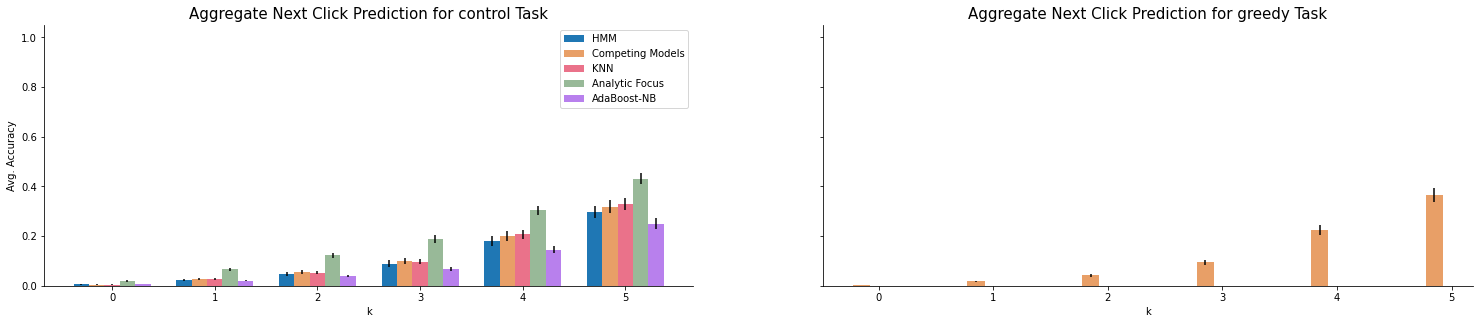

In [4]:
# Comparing next click prediction with Competing Models and HMM
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(4*6.4, 4.8))
plt.rcParams.update({'axes.titlesize': 15, 'axes.labelsize': 15, 'xtick.labelsize':12, 'xtick.labelsize':12})
axs[0].set(ylabel='Avg. Accuracy')
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.set(xlabel='k')
    ax.set_ylim((0, 1.05))
    
labels = ['ncp-1','ncp-5','ncp-10','ncp-20','ncp-50','ncp-100']
x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars
for ai, t in enumerate(['control', 'greedy']):
    df_temp_hmm = vast_results_hmm[vast_results_hmm.task == t][[f'ncp-{k}' for k in ks]]
    err_hmm = df_temp_hmm.std() / np.sqrt(len(df_temp_hmm))
    df_temp_cm = vast_results_cm[vast_results_cm.task == t][[f'ncp-{k}' for k in ks]]
    err_cm = df_temp_cm.std() / np.sqrt(len(df_temp_cm))
    df_temp_knn = vast_results_knn[vast_results_knn.task == t][[f'ncp-{k}' for k in ks]]
    err_knn = df_temp_knn.std() / np.sqrt(len(df_temp_knn))
    df_temp_af = vast_results_af[vast_results_af.task == t][[f'ncp-{k}' for k in ks]]
    err_af = df_temp_af.std() / np.sqrt(len(df_temp_af))
    df_temp_ada = vast_results_ada[vast_results_ada.task == t][[f'ncp-{k}' for k in ks]]
    err_ada = df_temp_ada.std() / np.sqrt(len(df_temp_ada))
    
    hmm_results = df_temp_hmm.mean()
    cm_results = df_temp_cm.mean()
    knn_results = df_temp_knn.mean()
    af_results = df_temp_af.mean()
    ada_results = df_temp_ada.mean()
    
    hmm_bar = axs[ai].bar(x - width*2, hmm_results, width, label='HMM', yerr=err_hmm)
    cm_bar = axs[ai].bar(x - width, cm_results, width, label='Competing Models', yerr=err_cm, color='#d95f02', alpha=0.6)
    knn_bar = axs[ai].bar(x, knn_results, width, label='KNN', yerr=err_knn, color='#DC143C', alpha=0.6)
    af_bar = axs[ai].bar(x + width, af_results, width, label='Analytic Focus', yerr=err_af, color='#548B54', alpha=0.6)
    ada_bar = axs[ai].bar(x + width*2, ada_results, width, label='AdaBoost-NB', yerr=err_ada, color='#8A2BE2', alpha=0.6)
    
    axs[ai].set_title(f'Aggregate Next Click Prediction for {t} Task')
    axs[ai].set_xticks(x, labels)
    axs[0].legend()
plt.show()

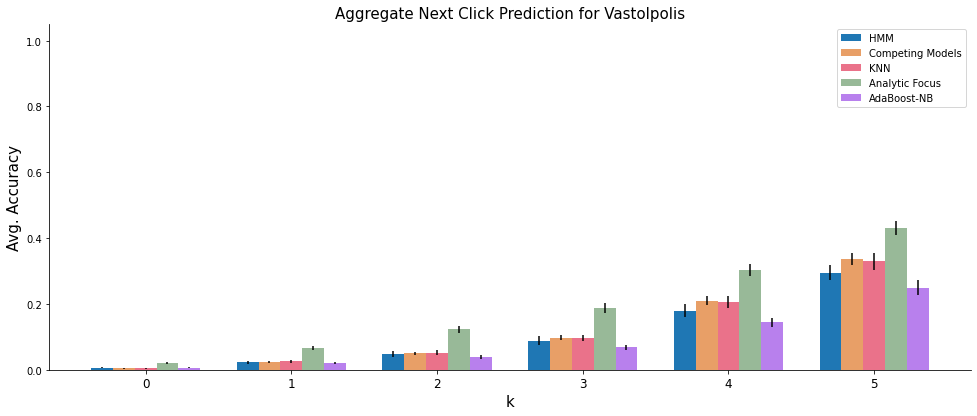

In [5]:
# Comparing next click prediction with Competing Models and HMM
# fig, axs = plt.subplots(1, 2, sharey=True, figsize=(2*6.4, 4.8))
fig = plt.figure(figsize=(2*6.4, 4.8))
plt.rcParams.update({'axes.titlesize': 15, 'axes.labelsize': 15, 'xtick.labelsize':12, 'xtick.labelsize':12})
ax = fig.add_axes([0,0,1,1])
ax.set(ylabel='Avg. Accuracy')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.set(xlabel='k')
ax.set_ylim((0, 1.05))

    
labels = ['ncp-1','ncp-5','ncp-10','ncp-20','ncp-50','ncp-100']
x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars
df_temp_hmm = vast_results_hmm[[f'ncp-{k}' for k in ks]]
err_hmm = df_temp_hmm.std() / np.sqrt(len(df_temp_hmm))
df_temp_cm = vast_results_cm[[f'ncp-{k}' for k in ks]]
err_cm = df_temp_cm.std() / np.sqrt(len(df_temp_cm))
df_temp_knn = vast_results_knn[[f'ncp-{k}' for k in ks]]
err_knn = df_temp_knn.std() / np.sqrt(len(df_temp_knn))
df_temp_af = vast_results_af[[f'ncp-{k}' for k in ks]]
err_af = df_temp_af.std() / np.sqrt(len(df_temp_af))
df_temp_ada = vast_results_ada[[f'ncp-{k}' for k in ks]]
err_ada = df_temp_ada.std() / np.sqrt(len(df_temp_ada))

hmm_results = df_temp_hmm.mean()
cm_results = df_temp_cm.mean()
knn_results = df_temp_knn.mean()
af_results = df_temp_af.mean()
ada_results = df_temp_ada.mean()

hmm_bar = ax.bar(x - width*2, hmm_results, width, label='HMM', yerr=err_hmm)
cm_bar = ax.bar(x - width, cm_results, width, label='Competing Models', yerr=err_cm, color='#d95f02', alpha=0.6)
knn_bar = ax.bar(x, knn_results, width, label='KNN', yerr=err_knn, color='#DC143C', alpha=0.6)
af_bar = ax.bar(x + width, af_results, width, label='Analytic Focus', yerr=err_af, color='#548B54', alpha=0.6)
ada_bar = ax.bar(x + width*2, ada_results, width, label='AdaBoost-NB', yerr=err_ada, color='#8A2BE2', alpha=0.6)

ax.set_title('Aggregate Next Click Prediction for Vastolpolis')
ax.set_xticks(x, labels)
ax.legend()
plt.show()

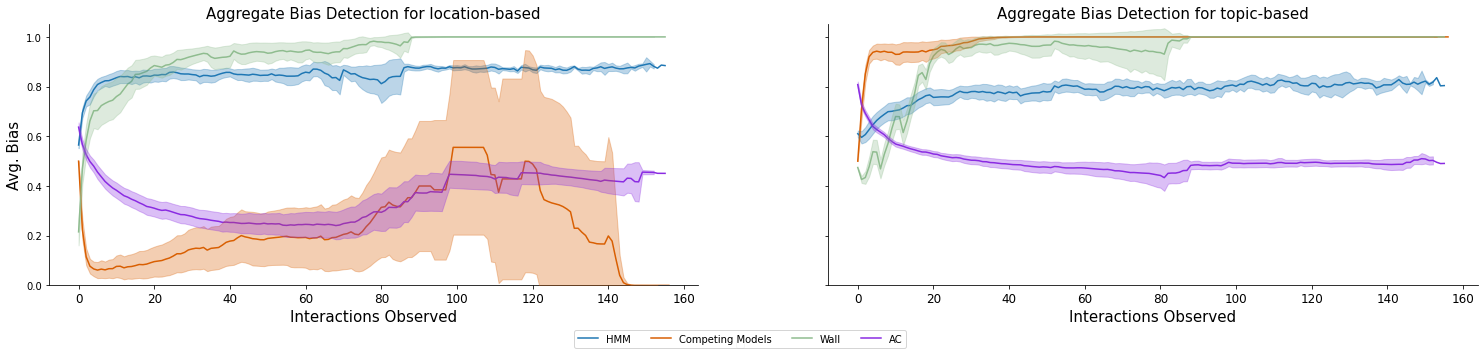

In [6]:
# Comparing bias with Wall, Competing Models, HMM, and AC
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(4*6.4, 4.8))
plt.rcParams.update({'axes.titlesize': 15, 'axes.labelsize': 15, 'xtick.labelsize':12, 'xtick.labelsize':12})
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.set(xlabel='Interactions Observed', ylabel='Avg. Bias')
    ax.set_ylim((0, 1.05))
#     ax.set_xlim((2, 12))

bias_metric_per_task_hmm = {'location-based': 'bias-bias_latitude___longitude', 'topic-based': 'bias-bias_topic'}
bias_metric_per_task_cm = {'location-based': 'bias-latitude___longitude', 'topic-based': 'bias-topic'}
bias_metric_per_task_wall = {'location-based': 'bias-latitude___longitude', 'topic-based': 'bias-topic'}
bias_metric_per_task_ac = {'location-based': 'bias-latitude___longitude', 'topic-based': 'bias-topic'}

t = 'control'
for ai, attr in enumerate(['location-based', 'topic-based']):
    bias_over_time_hmm = pd.DataFrame()
    bias_over_time_cm = pd.DataFrame()
    bias_over_time_wall = pd.DataFrame()
    bias_over_time_knn = pd.DataFrame()
    bias_over_time_ac = pd.DataFrame()
    for i, row in vast_results_ac[vast_results_ac.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_ac[attr]]
        bias_over_time_ac = pd.concat([bias_over_time_ac, temp_df], axis=1, ignore_index=True)
    for i, row in vast_results_hmm[vast_results_hmm.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_hmm[attr]]
        bias_over_time_hmm = pd.concat([bias_over_time_hmm, temp_df], axis=1, ignore_index=True)
    for i, row in vast_results_cm[vast_results_cm.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_cm[attr]]
        bias_over_time_cm = pd.concat([bias_over_time_cm, temp_df], axis=1, ignore_index=True)
    for i, row in vast_results_wall[vast_results_wall.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_wall[attr]]
        bias_over_time_wall = pd.concat([bias_over_time_wall, temp_df], axis=1, ignore_index=True)
        
    sems_hmm = bias_over_time_hmm.std(axis=1) / np.sqrt(bias_over_time_hmm.count(axis=1))
    mean_hmm = bias_over_time_hmm.mean(axis=1)
    
    sems_cm = bias_over_time_cm.std(axis=1) / np.sqrt(bias_over_time_cm.count(axis=1))
    mean_cm = bias_over_time_cm.mean(axis=1)
    
    sems_wall = bias_over_time_wall.std(axis=1) / np.sqrt(bias_over_time_wall.count(axis=1))
    mean_wall = bias_over_time_wall.mean(axis=1)
    
    sems_knn = bias_over_time_knn.std(axis=1) / np.sqrt(bias_over_time_knn.count(axis=1))
    mean_knn = bias_over_time_knn.mean(axis=1)
    
    sems_ac = bias_over_time_ac.std(axis=1) / np.sqrt(bias_over_time_ac.count(axis=1))
    mean_ac = bias_over_time_ac.mean(axis=1)
    
    mean_hmm.plot(ax=axs[ai], title=f'Aggregate Bias Detection for {attr}', label='HMM', color='#1F77B4')
    mean_cm.plot(ax=axs[ai], title=f'Aggregate Bias Detection for {attr}', label='Competing Models', color='#d95f02')
    mean_wall.plot(ax=axs[ai], title=f'Aggregate Bias Detection for {attr}', label='Wall', color='#8FBC8F')
    mean_ac.plot(ax=axs[ai], title=f'Aggregate Bias Detection for {attr}', label='AC', color='#8A2BE2')
    
    axs[ai].fill_between(list(range(len(mean_hmm))), mean_hmm-2*sems_hmm,mean_hmm+2*sems_hmm, color='#1F77B4', alpha=0.3, zorder=100)
    axs[ai].fill_between(list(range(len(mean_cm))), mean_cm-2*sems_cm,mean_cm+2*sems_cm, color='#d95f02', alpha=0.3, zorder=100)
    axs[ai].fill_between(list(range(len(mean_wall))), mean_wall-2*sems_wall,mean_wall+2*sems_wall, color='#8FBC8F', alpha=0.3, zorder=100)
    axs[ai].fill_between(list(range(len(mean_ac))), mean_ac-2*sems_ac,mean_ac+2*sems_ac, color='#8A2BE2', alpha=0.3, zorder=100)

    handles, labels = axs[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.07))